# Collaborative Filtering with Netflix Data

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import random
import math
from pathlib import Path
PATH = Path("./data/")
list(PATH.iterdir())

[PosixPath('data/clean_train.csv'),
 PosixPath('data/clean_combined_data_3.txt'),
 PosixPath('data/clean_combined_data_2.txt'),
 PosixPath('data/combined_data_1.txt'),
 PosixPath('data/combined_data_3.txt'),
 PosixPath('data/README'),
 PosixPath('data/clean_data.csv'),
 PosixPath('data/qualifying.txt'),
 PosixPath('data/probe.txt'),
 PosixPath('data/clean_valid.csv'),
 PosixPath('data/model_tmp.pth'),
 PosixPath('data/movie_titles.csv'),
 PosixPath('data/clean_combined_data_1.txt'),
 PosixPath('data/clean_test.csv'),
 PosixPath('data/combined_data_2.txt'),
 PosixPath('data/clean_combined_data_4.txt'),
 PosixPath('data/combined_data_4.txt')]

## Data Cleaning

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
PATH = Path("./data/")
list(PATH.iterdir())

[PosixPath('data/clean_train.csv'),
 PosixPath('data/clean_combined_data_3.txt'),
 PosixPath('data/clean_combined_data_2.txt'),
 PosixPath('data/combined_data_1.txt'),
 PosixPath('data/combined_data_3.txt'),
 PosixPath('data/README'),
 PosixPath('data/clean_data.csv'),
 PosixPath('data/qualifying.txt'),
 PosixPath('data/probe.txt'),
 PosixPath('data/clean_valid.csv'),
 PosixPath('data/model_tmp.pth'),
 PosixPath('data/movie_titles.csv'),
 PosixPath('data/clean_combined_data_1.txt'),
 PosixPath('data/clean_test.csv'),
 PosixPath('data/combined_data_2.txt'),
 PosixPath('data/clean_combined_data_4.txt'),
 PosixPath('data/combined_data_4.txt')]

In [4]:
! head -n 5 ./data/combined_data_1.txt

1:
1488844,3,2005-09-06
822109,5,2005-05-13
885013,4,2005-10-19
30878,4,2005-12-26


In [5]:
txt_files = ['combined_data_1.txt', 'combined_data_2.txt', 'combined_data_3.txt', 'combined_data_4.txt']
for file in txt_files: 
    full_file = str(PATH) + '/' + file
    with open(full_file) as f:
        content = f.readlines()
        clean_content_fname = str(PATH) + '/clean_' + str(file)
        clean_content = open(clean_content_fname, 'w')
        for line in content:
            if ':' in line:
                mv_id = line
                mv_id = mv_id.replace(':', '')
                mv_id = mv_id.replace('\n', '')
            else:
                line = mv_id + ',' + line
                clean_content.write(line)
        clean_content.close()

In [6]:
df1 = pd.read_csv(PATH/"clean_combined_data_1.txt", names = ['userId','rating','date'], index_col = None)
df2 = pd.read_csv(PATH/"clean_combined_data_2.txt", names = ['userId','rating','date'], index_col = None)
df3 = pd.read_csv(PATH/"clean_combined_data_3.txt", names = ['userId','rating','date'], index_col = None)
df4 = pd.read_csv(PATH/"clean_combined_data_4.txt", names = ['userId','rating','date'], index_col = None)

In [7]:
def append_frames(*args):
    df = args[0]
    for frame in args[1:]: 
        df.append(frame)
        # del frame -- TODO: needed or not?
    return df

In [8]:
df = df1
del df1 #deallocation
df = df.append(df2)
del df2 #deallocation
df = df.append(df3)
del df3 #deallocation
df = df.append(df4)
del df4 #deallocation

In [9]:
df.shape

(100480507, 3)

In [10]:
df.head()

,userId,rating,date
1,1488844,3,2005-09-06
1,822109,5,2005-05-13
1,885013,4,2005-10-19
1,30878,4,2005-12-26
1,823519,3,2004-05-03


In [11]:
df['movieId'] = df.index.values

In [12]:
df = df.reset_index(drop=True)

In [18]:
sum(pd.notnull(df['rating'])) - len(df)

0

In [20]:
df_nonull = df[pd.notnull(df['rating'])]

In [21]:
df_nonull.isnull().values.any()

False

In [22]:
df_nonull.to_csv(PATH/"clean_data.csv",index=False)

In [23]:
df = pd.read_csv(PATH/"clean_data.csv")

In [24]:
df.head()

,userId,rating,date,movieId
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1


## Encode Data

In [25]:
# split train and validation before encoding
df['date'] =pd.to_datetime(df.date)
df = df.sort_values(by='date')
df.head()

,userId,rating,date,movieId
56431994,510180,4,1999-11-11,10341
9056171,510180,5,1999-11-11,1798
58698779,510180,3,1999-11-11,10774
48101611,510180,2,1999-11-11,8651
81893208,510180,2,1999-11-11,14660


In [26]:
test_size = 1000000
valid_size = 1000000
train_size = len(df) - (test_size+valid_size)
test_df = df[-2000000:]
valid_df = df[-4000000:-2000000]
train_df = df.head(train_size)
print(train_df.shape, valid_df.shape, test_df.shape)
print(df.shape)
del df

(98480507, 4) (2000000, 4) (2000000, 4)
(100480507, 4)


In [27]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continous ids. 
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [28]:
train_df = encode_data(train_df)
valid_df = encode_data(valid_df, train_df)
test_df = encode_data(test_df, train_df)
train_df.head()

,userId,rating,date,movieId
56431994,0,4,1999-11-11,0
9056171,0,5,1999-11-11,1
58698779,0,3,1999-11-11,2
48101611,0,2,1999-11-11,3
81893208,0,2,1999-11-11,4


In [29]:
train_df.to_csv(PATH/"clean_train.csv",index=False)
valid_df.to_csv(PATH/"clean_valid.csv", index=False)
test_df.to_csv(PATH/"clean_test.csv",index=False)

## Restart Point

In [21]:
train_df = pd.read_csv(PATH/"clean_train.csv")
valid_df = pd.read_csv(PATH/"clean_valid.csv")
test_df = pd.read_csv(PATH/"clean_test.csv")

In [22]:
train_df.head()

,userId,rating,date,movieId
0,0,4,1999-11-11,0
1,0,5,1999-11-11,1
2,0,3,1999-11-11,2
3,0,2,1999-11-11,3
4,0,2,1999-11-11,4


In [23]:
train_df.drop('date',axis=1,inplace=True)
valid_df.drop('date',axis=1,inplace=True)
test_df.drop('date',axis=1,inplace=True)

In [24]:
type(train_df['userId'][0])

numpy.int64

In [25]:
train_df = train_df.astype('int32',copy=False)
valid_df = valid_df.astype('int32', copy=False)
test_df = test_df.astype('int32', copy=False)

In [26]:
type(train_df['userId'][0])

numpy.int32

## DataSet and DataLoader

In [27]:
from torch.utils import data
class NetflixDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.length = len(df)
        self.y = torch.FloatTensor(df['rating'].values)
        self.x = torch.LongTensor(df.drop('rating',axis=1).values)
        self.transform = transform
        
    def __len__(self):
        return self.length
    
    def __getitem__(self,index):
        sample = {'x':self.x[index], 'y':self.y[index]}
        return sample

In [28]:
train_ds = NetflixDataset(train_df)
valid_ds = NetflixDataset(valid_df)
test_ds = NetflixDataset(test_df)

In [29]:
from torch.utils.data import Dataset, DataLoader

batch_size = 100000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
# for test we use shuffle=False
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False,num_workers=4)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False,num_workers=4)

## Baseline Model

In [30]:
# mean of two means (mean(movie-rating) mean(user-rating))
user_means = train_df.groupby(['userId']).mean()['rating']
movie_means = train_df.groupby(['movieId']).mean()['rating']
total_mean = train_df['rating'].mean()

In [31]:
import functools
loss = []
for i,row in test_df.iterrows():
    val = (user_means[row.userId] + movie_means[row.movieId])/2
    loss.append((val-row.rating)**2)
print(functools.reduce(lambda x, y: x + y, loss) / len(loss))

1.334860792324501


## Neural Network Model

In [32]:
# Note here there is no matrix multiplication, we could potentially make the embeddings of different sizes.
# Here we could get better results by keep playing with regularization.
    
class CollabFNet(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=500):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(num_users, emb_size), nn.Embedding(num_items, emb_size)])
        self.lin1 = nn.Linear(emb_size*2, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm1d(emb_size*2)
        self.bn2 = nn.BatchNorm1d(n_hidden)
        
    def forward(self, u, v):
        U = self.embs[0](u)
        V = self.embs[1](v)
        x = self.bn1(torch.cat([U, V], dim=1))
        x = F.relu(x)
        x = self.drop1(x)
        x = self.lin1(x)
        x = F.relu(self.bn2(x))
        x = self.drop2(x)
        x = self.lin2(x)
        return x

## Training and Learning Rate Functions

In [33]:
def train_loop(model, epochs, lr=0.01, wd=0.0):
    # optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print("loss ", loss)
        val_loss(model, valid_dl)
        
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim
        
def train_triangle(model, epochs, train_dl=train_dl, lrs=None, verbose=False):
    idx=0
    for i in range(epochs): 
        model.train()
        total = 0
        sum_loss = 0
        for sample in train_dl:
            optim = get_optimizer(model, lr = lrs[idx], wd = 0.00001)
            x = sample['x'].to(device)
            y = sample['y'].unsqueeze(1).to(device)
            batch = y.shape[0]
            y_hat = model(x[:,0], x[:,1])
            loss = F.mse_loss(y_hat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            total += batch
            sum_loss += batch*(loss.item())
            if verbose: print(sum_loss/total)
        print("train loss ", sum_loss/total)
        val_loss(model, valid_dl)
    return sum_loss/total

def val_loss(model, valid_dl):
    model.eval()
    with torch.no_grad():
        total = 0
        sum_loss = 0
        correct = 0
        for sample in valid_dl:
            x = sample['x'].to(device)
            y = sample['y'].unsqueeze(1).to(device)
            batch = y.shape[0]
            y_hat = model(x[:,0], x[:,1])
            loss = F.mse_loss(y_hat, y)
            sum_loss += batch*(loss.item())
            total += batch
        print("val loss", sum_loss/total)
        return sum_loss/total

def sltr(num_epochs, train_size, eta_max=0.01, cut_frac=0.1, ratio=32):
    '''Slanted triangular learning rates written from ULMFiT paper
        see [ULMFit](https://arxiv.org/abs/1801.06146)
    '''
    training_iterations = num_epochs * train_size
    cut = math.floor(training_iterations * cut_frac)
    lr = [None for _ in range(training_iterations)]
    for t in range(training_iterations):
        if t<cut: 
            p=t/cut
        else: 
            p=1-((t-cut)/(cut*(1/cut_frac-1)))
        lr[t] = eta_max * (1+p*(ratio-1))/ratio
    return lr

def learning_rate_range(model, train_dl, lr_high=0.1, epochs=2):
    save_model(model, str(PATH/"model_tmp.pth"))
    losses = []
    iterations = len(train_dl) * epochs
    delta = (lr_high / iterations)
    lrs = [i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for sample in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            y = sample['y'].unsqueeze(1).to(device)
            x = sample['x'].to(device)
            batch = y.shape[0]
            y_hat = model(x[:,0],x[:,1])
            loss = F.mse_loss(y_hat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind+=1
    load_model(model, str(PATH/"model_tmp.pth"))
    return lrs, losses

def save_model(model, location):
    torch.save(model.state_dict(), location)

def load_model(model, location):
    model.load_state_dict(torch.load(location))

## Finding Ideal Learning Rate Triangle

In [34]:
num_users = len(train_df.userId.unique())
num_items = len(train_df.movieId.unique())

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CollabFNet(num_users, num_items, emb_size=100)
if torch.cuda.device_count()>1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)

CollabFNet(
  (embs): ModuleList(
    (0): Embedding(477948, 100)
    (1): Embedding(17768, 100)
  )
  (lin1): Linear(in_features=200, out_features=500, bias=True)
  (lin2): Linear(in_features=500, out_features=1, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [36]:
lrs, losses = learning_rate_range(model, train_dl, lr_high=0.02)

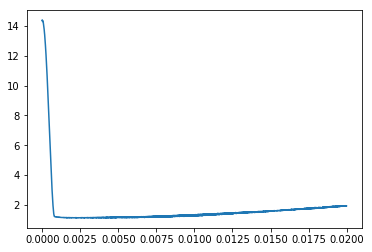

In [37]:
plt.plot(lrs, losses)

In [38]:
lrs = sltr(3, len(train_dl), eta_max=0.005)

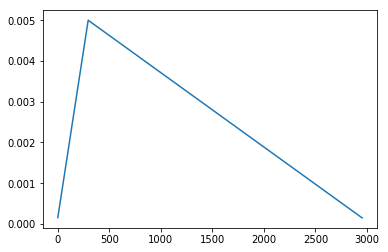

In [39]:
plt.plot(lrs)

## Actual Training

In [40]:
train_triangle(model, epochs=3, lrs=lrs)

train loss  2.0828457535871485
val loss 1.3240366217368453
train loss  1.0903149556996565
val loss 1.318040445565114
train loss  1.0760576321140825
val loss 1.3065649346413075


1.0760576321140825


# References
* This notebook is based on [lesson 5 of Jeremy Howard's Deep Learning Course](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb)